In [2]:
!pip install ftfy regex tqdm git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00


In [3]:
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
print("所有包导入成功！")

所有包导入成功！


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print(f"模型已加载到: {device}")

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 108MiB/s]


模型已加载到: cuda


In [6]:
image_urls = [
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba",  # 猫
    "https://images.unsplash.com/photo-1552053831-71594a27632d",  # 狗
    "https://images.unsplash.com/photo-1549317661-bd32c8ce0db2"   # 车
]

images = []
for url in image_urls:
    try:
        images.append(Image.open(urlopen(url)))
        print(f"成功加载图片: {url}")
    except Exception as e:
        print(f"加载图片失败 {url}: {e}")
        images.append(Image.new('RGB', (224, 224), color=(73, 109, 137)))

print(f"总共成功加载 {len(images)} 张图片")

text_descriptions = ["a photo of a cat", "a photo of a dog", "a photo of a car"]
print("文本描述:", text_descriptions)

成功加载图片: https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba
成功加载图片: https://images.unsplash.com/photo-1552053831-71594a27632d
成功加载图片: https://images.unsplash.com/photo-1549317661-bd32c8ce0db2
总共成功加载 3 张图片
文本描述: ['a photo of a cat', 'a photo of a dog', 'a photo of a car']


In [7]:
text_inputs = torch.cat([clip.tokenize(desc) for desc in text_descriptions]).to(device)

image_inputs = torch.stack([preprocess(img) for img in images]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_inputs)
    text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("图文相似度矩阵:")
print(similarity.cpu().numpy())

图文相似度矩阵:
[[9.932e-01 6.905e-03 8.553e-05]
 [1.623e-03 9.980e-01 1.122e-04]
 [2.130e-04 8.039e-04 9.990e-01]]


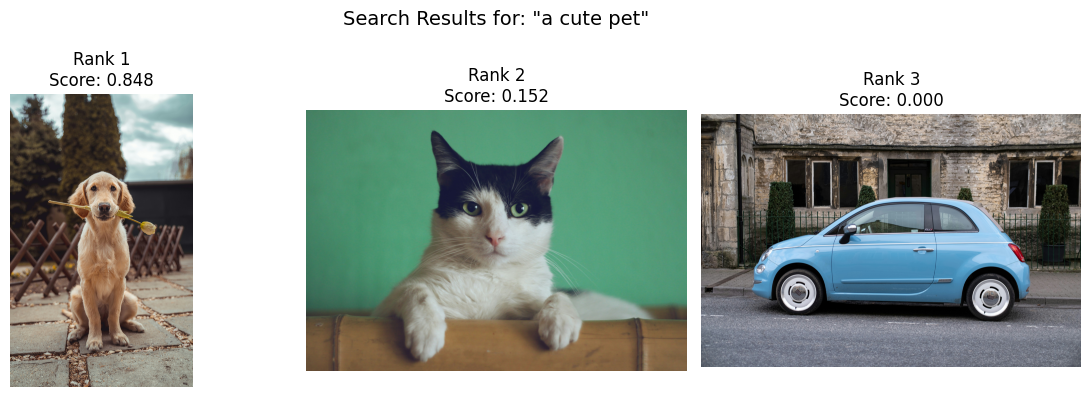

In [8]:
query_text = "a cute pet"
text_input = clip.tokenize([query_text]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * text_features @ image_features.T).softmax(dim=-1)

values, indices = similarity[0].topk(3)

plt.figure(figsize=(12, 4))
for i, (score, idx) in enumerate(zip(values, indices)):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[idx])
    plt.title(f"Rank {i+1}\nScore: {score:.3f}")
    plt.axis('off')
plt.suptitle(f'Search Results for: "{query_text}"', fontsize=14)
plt.tight_layout()
plt.show()